In [14]:
import pandas as pd
import numpy as np


In [9]:
# Load datasets
daily_data = pd.read_csv('BBCA.JK.csv')

In [10]:
# Check for missing values
print("Missing values in Daily Data:")
print(daily_data.isnull().sum())

Missing values in Daily Data:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [11]:
daily_data.fillna(method='ffill', inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_28588\1918574375.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data.fillna(method='ffill', inplace=True)


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
daily_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.fit_transform(daily_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

In [13]:
train_size = int(len(daily_data) * 0.8)
train_data, test_data = daily_data[:train_size], daily_data[train_size:]

### LSTM Model

In [20]:

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # 3 is the index of 'Close'
    return np.array(X), np.array(y)

seq_length = 100
X_train, y_train = create_sequences(train_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values, seq_length)
X_test, y_test = create_sequences(test_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values, seq_length)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
35/35 [==============================] - 13s 155ms/step - loss: 0.0179 - val_loss: 0.0089
Epoch 2/20
35/35 [==============================] - 4s 115ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 3/20
35/35 [==============================] - 4s 122ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 4/20
35/35 [==============================] - 4s 107ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 5/20
35/35 [==============================] - 4s 105ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 6/20
35/35 [==============================] - 4s 109ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 7/20
35/35 [==============================] - 4s 103ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 8/20
35/35 [==============================] - 4s 101ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 9/20
35/35 [==============================] - 4s 105ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/20
35/35 [==============================] - 3s 97ms/step - loss: 0.0026 - val_loss: 0.0017

7/7 [==============================] - 2s 38ms/step


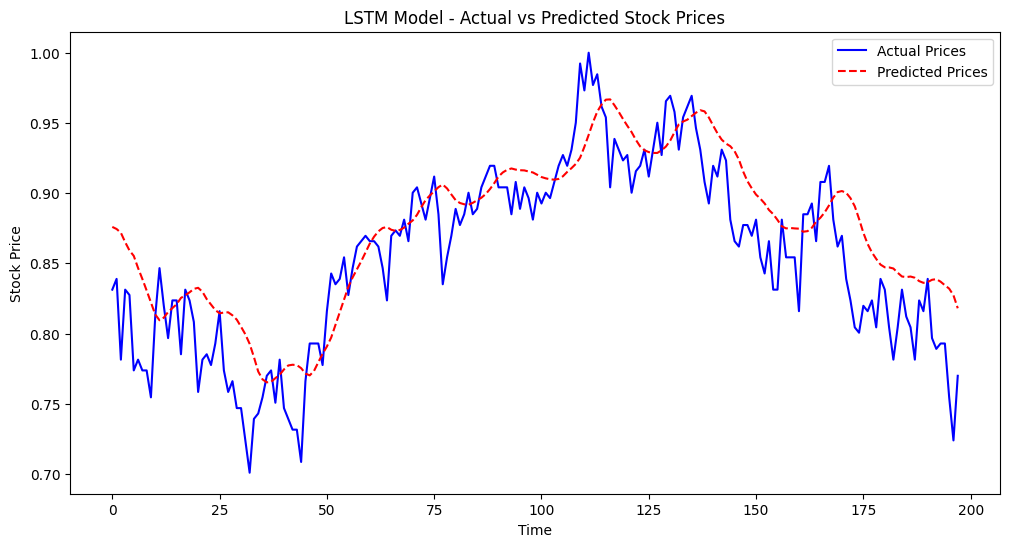

In [22]:
import matplotlib.pyplot as plt

# Generate predictions
predicted_prices = model.predict(X_test)

# Plot Actual vs. Predicted
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Prices", color='red', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("LSTM Model - Actual vs Predicted Stock Prices")
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


mse = mean_squared_error(y_test, predicted_prices)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

mae = mean_absolute_error(y_test, predicted_prices)
print(f"Mean Absolute Error: {mae}")

from sklearn.metrics import r2_score

r2 = r2_score(y_test, predicted_prices)
print(f"R-squared: {r2}")


Mean Squared Error: 0.0013311405405575238
Root Mean Squared Error: 0.03648479875999762
Mean Absolute Error: 0.028941411141562637
R-squared: 0.6837474513057565


### GRU Model

In [15]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # 3 is the index of 'Close'
    return np.array(X), np.array(y)

seq_length = 100  # You can adjust this based on experimentation
X_train, y_train = create_sequences(train_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values, seq_length)
X_test, y_test = create_sequences(test_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values, seq_length)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

def build_gru_model(input_shape):
    model = Sequential()
    
    # First GRU layer
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout for regularization
    
    # Second GRU layer
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense layer to produce the output
    model.add(Dense(units=1))  # Output is a single value (e.g., Close price)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


In [18]:
# Define input shape (seq_length, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the GRU model
gru_model = build_gru_model(input_shape)

# Print model summary
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 50)           8700      
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 24,051
Trainable params: 24,051
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = gru_model.fit(
    X_train, y_train,
    epochs=50,  # Adjust the number of epochs
    batch_size=32,  # Adjust the batch size
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
35/35 [==============================] - 14s 161ms/step - loss: 0.0230 - val_loss: 0.0018
Epoch 2/50
35/35 [==============================] - 4s 115ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 3/50
35/35 [==============================] - 4s 120ms/step - loss: 0.0035 - val_loss: 9.3464e-04
Epoch 4/50
35/35 [==============================] - 4s 111ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/50
35/35 [==============================] - 4s 126ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/50
35/35 [==============================] - 5s 129ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 7/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0023 - val_loss: 8.5395e-04
Epoch 8/50
35/35 [==============================] - 4s 114ms/step - loss: 0.0024 - val_loss: 7.0590e-04
Epoch 9/50
35/35 [==============================] - 4s 120ms/step - loss: 0.0022 - val_loss: 7.1442e-04
Epoch 10/50
35/35 [==============================] - 4s 112ms/step - loss: 0.0021 -

In [20]:
test_loss = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: 0.0008016490028239787


In [21]:
predictions = gru_model.predict(X_test)

7/7 [==============================] - 1s 27ms/step


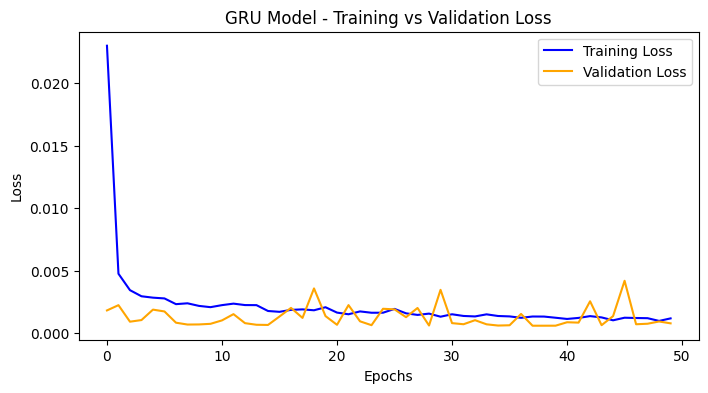

In [22]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GRU Model - Training vs Validation Loss")
plt.legend()
plt.show()


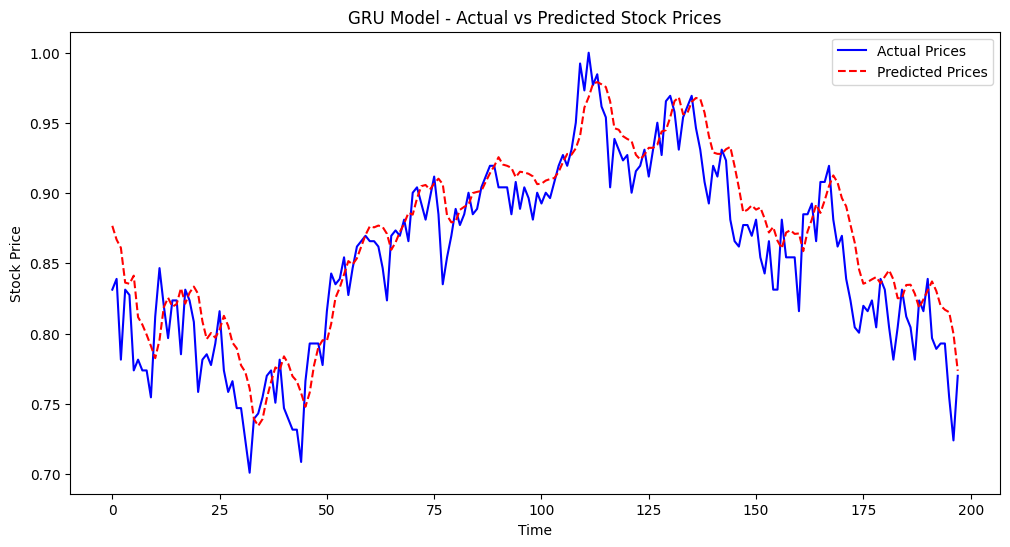

In [24]:
# Plot Actual vs. Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red', linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("GRU Model - Actual vs Predicted Stock Prices")
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute error metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.0008016488623938685
Root Mean Squared Error (RMSE): 0.028313404288320198
Mean Absolute Error (MAE): 0.022147972562199754
R-squared (R²): 0.8095441554325149
